In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

drive.mount('/content/drive')

Using device: cuda
PyTorch version: 2.9.0+cu126
Mounted at /content/drive


In [8]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

CSV_PATH = '/content/drive/MyDrive/AI_lab/insurance.csv'

if not os.path.exists(CSV_PATH):
    print(f"Error: The file '{CSV_PATH}' was not found.")
    print("Please ensure the file is uploaded to your Google Drive and the path is correct.")
    print("You can verify the path by browsing your Drive in the left panel in Colab (Files > drive > MyDrive).")
else:
    df = pd.read_csv(CSV_PATH)

    print(f"Loaded Dataset Shape: {df.shape}")

    le = LabelEncoder()
    df['sex'] = le.fit_transform(df['sex'])
    df['smoker'] = le.fit_transform(df['smoker'])

    df = pd.get_dummies(df, columns=['region'], drop_first=True)

    df['charges'] = df['charges'] / 10000.0

    X = df.drop('charges', axis=1).values.astype(np.float32)
    y = df['charges'].values.astype(np.float32)

    print("\n✓ Data prepared. Variables X and y are defined.")
    print(f"Number of final features: {X.shape[1]}")

Loaded Dataset Shape: (1338, 7)

✓ Data prepared. Variables X and y are defined.
Number of final features: 8


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape[0]} samples")
print(f"Test set size: {X_test_scaled.shape[0]} samples")

Training set size: 1070 samples
Test set size: 268 samples


In [10]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, hidden_size3=32):
        super(RegressionModel, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

input_size = X_train_scaled.shape[1]
model = RegressionModel(input_size).to(device)

print(model)

RegressionModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
criterion = nn.MSELoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.0005


In [13]:
num_epochs = 200

train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(X_batch)

        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [20/200] | Train Loss: 0.2196 | Test Loss: 0.2051
Epoch [40/200] | Train Loss: 0.1938 | Test Loss: 0.2221
Epoch [60/200] | Train Loss: 0.1725 | Test Loss: 0.2459
Epoch [80/200] | Train Loss: 0.1630 | Test Loss: 0.2565
Epoch [100/200] | Train Loss: 0.1495 | Test Loss: 0.2686
Epoch [120/200] | Train Loss: 0.1430 | Test Loss: 0.2897
Epoch [140/200] | Train Loss: 0.1331 | Test Loss: 0.2837
Epoch [160/200] | Train Loss: 0.1252 | Test Loss: 0.2999
Epoch [180/200] | Train Loss: 0.1216 | Test Loss: 0.3027
Epoch [200/200] | Train Loss: 0.1108 | Test Loss: 0.3000
------------------------------------------------------------
Training complete!


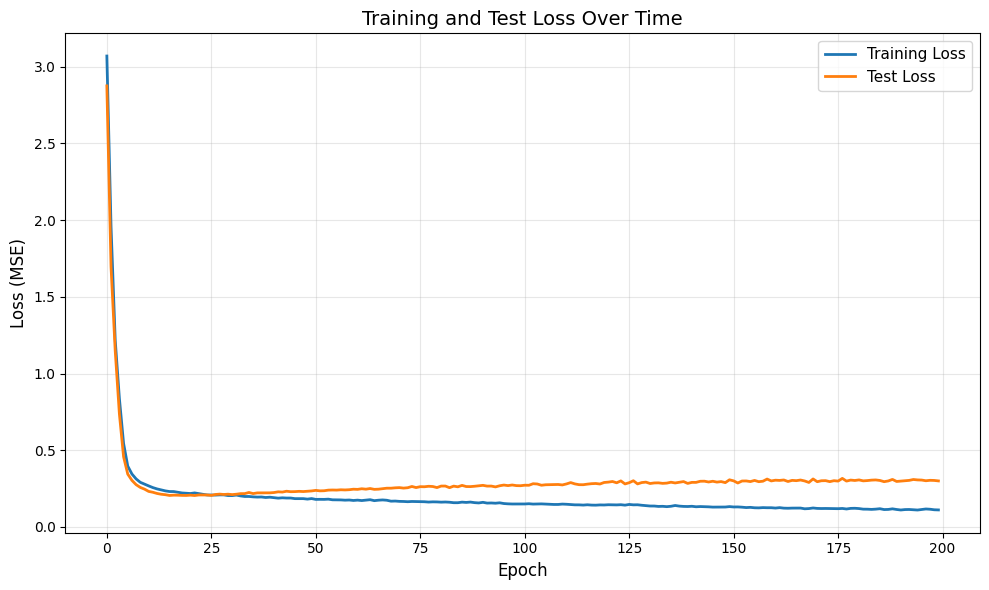

Final Training Loss: 0.1108
Final Test Loss: 0.3000


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

SCALE_FACTOR = 10000.0

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print("\nInterpretation:")
print(f"On average, predictions are off by ${mae * SCALE_FACTOR:,.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in medical charges")

Model Performance on Test Set:
Mean Squared Error (MSE):  0.2752
Root Mean Squared Error (RMSE): 0.5246
Mean Absolute Error (MAE): 0.3286
R² Score: 0.8227

Interpretation:
On average, predictions are off by $3,285.67
Model explains 82.27% of the variance in medical charges


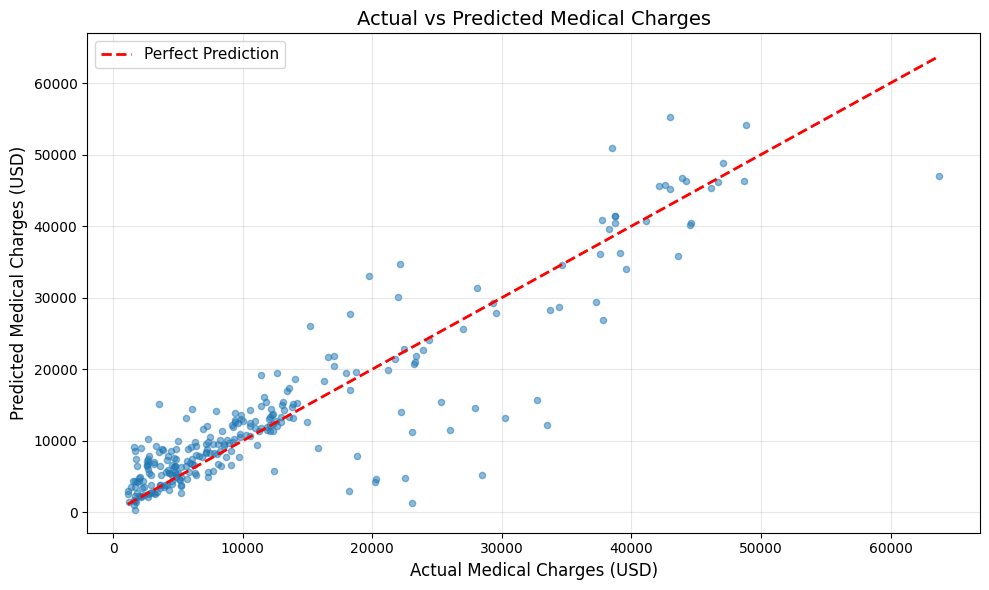

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true * SCALE_FACTOR, y_pred * SCALE_FACTOR, alpha=0.5, s=20)
plt.plot([y_true.min() * SCALE_FACTOR, y_true.max() * SCALE_FACTOR],
         [y_true.min() * SCALE_FACTOR, y_true.max() * SCALE_FACTOR],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
plt.title('Actual vs Predicted Medical Charges', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
torch.save(model.state_dict(), 'insurance_regression_model.pth')
print("✓ Model saved to 'insurance_regression_model.pth'")

✓ Model saved to 'insurance_regression_model.pth'
